In [628]:
import numpy as np
import torch
import scipy
from bsgp.kernels import FullPrecisionRBF as BgpFullRBF
from bsgp.utils import apply_pca
import tensorflow as  tf
from sklearn.model_selection import train_test_split
from torch.utils.data import  TensorDataset
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow

In [629]:
latent_space = 10
T = 100
D = 62

In [630]:
def create_dataset(dataset='mocap_data', d=5, T=100, normalize=False, fold=0):
    dataset_path = ('./data/' + dataset + '.npz')
    dataset = np.load(dataset_path)
    X_NTxD, X_NxTD, Y = dataset['X_NTxD'], dataset['X_NxTD'], dataset['Y']

    D = X_NTxD.shape[1]
    """
    # normalize data
    if normalize:
        X_NxTd = (X_NxTd - np.mean(X_NxTd, axis=0)) / np.std(X_NxTd, axis=0)

    # apply PCA on X_NTxD
    X_NTxd, Pd = apply_pca(X_NTxD, n_comp=d) 

    # reshape X_NTxd -> X_NxTd
    X_NxTd = X_NTxd.reshape(N, T*d) # N x Td

    """
    # split data 
    if normalize:
        X_NTxD = (X_NTxD - np.mean(X_NTxD, axis=0)) / np.std(X_NTxD, axis=0)
        X_NxTD = X_NTxD.reshape(X_NxTD.shape[0], T*D) # N x TD
    X_NxTD_train, X_NxTD_test, Y_train, Y_test = train_test_split(X_NxTD, Y, test_size=0.20, random_state=fold, stratify=Y)
    X_NTxD_train = X_NxTD_train.reshape(X_NxTD_train.shape[0]*T, D) # NtrainT x  D
    X_NTxD_test =  X_NxTD_test.reshape(X_NxTD_test.shape[0]*T, D) # NtestT x  D
    X_NTxd_train, Pd = apply_pca(X_NTxD_train, n_comp=d) # NtrainT x d
    X_NTxd_test = X_NTxD_test @ Pd # NestT x d
    X_NxTd_train = X_NTxd_train.reshape(X_NxTD_train.shape[0], T*d) # Ntrain x Td
    X_NxTd_test = X_NTxd_test.reshape(X_NxTD_test.shape[0], T*d) # Ntest x Td
    
    # TO BE IMPLEMENTED
    # 1) train_test_split X_NxTD into X_NxTD_train, X_NxTD_test
    # 2) Reshape X_NxTD_train into X_NTxD_train [NT x D] and X_NxTD_test into X_NTxD_test [NT x D]
    # 3) fit_trainsform PCA on X_NTxD_train to obtain X_NTxd_train [NT x d] and save Pd [D x d]
    # 4) transform PCA on X_NTxD_test to obtain X_NTxd_test
    # 5) Reshape X_NTxd_train into X_NxTd_train, X_NTxd_test into X_NxTd_test
    return X_NxTd_train, Y_train, X_NxTd_test, Y_test, Pd, dataset['sensors_names'].tolist(), dataset['sensors_mask'].tolist()

In [631]:
X_train, Y_train, X_test, Y_test, Pd, sensors_names, sensors_mask = create_dataset(dataset='mocap_data', d=latent_space, T=T, normalize=False)
print('X_train: ', X_train.shape) # Ntrain x Td
print(' walk: ', np.sum(Y_train==0)) 
print(' run: ', np.sum(Y_train==1)) 
print('X_test: ', X_test.shape) # Ntest x Td
print(' walk: ', np.sum(Y_test==0)) 
print(' run: ', np.sum(Y_test==1)) 
print('Pd: ', Pd.shape) # D x d

X_train:  (84, 1000)
 walk:  47
 run:  37
X_test:  (21, 1000)
 walk:  12
 run:  9
Pd:  (62, 10)


In [632]:
def get_lower_triangular_from_diag(d):
    lengthscales = np.full((d,), d**0.5, dtype=np.float64)
    Lambda = np.diag(1/(lengthscales**2))
    L = scipy.linalg.cholesky(Lambda, lower=True)
    return tfp.math.fill_triangular_inverse(L, upper=False) 
def kron_ones(P, t):
    P = tf.linalg.LinearOperatorFullMatrix([P])
    H = tf.linalg.LinearOperatorFullMatrix([tf.eye(t, dtype=tf.float64)])
    return tf.squeeze(tf.linalg.LinearOperatorKronecker([H, P]).to_dense())

class FullPrecisionRBF(gpflow.kernels.Kernel):  

    def __init__(self, **kwargs):
        randomized = kwargs["randomized"]
        self.d = kwargs["d"]
        self.input_dim = self.d
        self.T = kwargs["T"]
        self._v = kwargs["variance"]
        if not randomized:
            L = get_lower_triangular_from_diag(self.d)
        super().__init__()
        self.L = tf.Variable(L, name='L', dtype=tf.float64)
        self.logvariance = tf.Variable(np.log(self._v), dtype=tf.float64, name='log_variance', trainable=False)
        self.variance = tf.exp(self.logvariance)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        N1 = tf.squeeze(tf.shape(X)[:-1])
        N2 = tf.squeeze(tf.shape(X2)[:-1])
        Lambda = self.precision() # recover LLᵀ

        # compute z, z2
        z = self._z(X, Lambda) # N1x1 array
        z2 = self._z(X2, Lambda) # N2x1 array
        # compute X(X2Λ)ᵀ
        X2Lambda = tf.linalg.matmul(X2, Lambda)
        XX2LambdaT = tf.linalg.matmul(X, tf.transpose(X2Lambda)) # N1xN2 matrix
        # compute z1ᵀ 
        ones_N2 = tf.ones(shape=(N2,1), dtype=tf.float64) # N2x1 array
        zcol = tf.linalg.matmul(z, tf.transpose(ones_N2)) # N1xN2 matrix
        # compute 1z2ᵀ 
        ones_N1 = tf.ones(shape=(N1,1), dtype=tf.float64) # N1x1 array
        zrow = tf.linalg.matmul(ones_N1, tf.transpose(z2)) # N1xN2 matrix

        exp_arg = zcol - 2*XX2LambdaT + zrow
        Kxx = tf.math.exp(-0.5 * exp_arg)
        return self.variance * Kxx
    
    def K_diag(self, X):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))
    
    def Kdiag(self, X):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))
    
    def _z(self, X, Lambda):
        XLambda = tf.linalg.matmul(X, Lambda)
        XLambdaX = tf.math.multiply(XLambda, X)
        return tf.math.reduce_sum(XLambdaX, axis=1, keepdims=True)
    
    def precision(self):
        L = tfp.math.fill_triangular(self.L, upper=False) # recover L matrix from L array
        Lambda = tf.linalg.matmul(L, tf.transpose(L))
        Lambda_expanded = kron_ones(Lambda, self.T)
        return Lambda_expanded
    
    def precision_off_diagonals(self):
        diag_L = tf.linalg.tensor_diag_part(self.precision())
        return self.precision() - tf.linalg.diag(diag_L)
    
    def precision_off_diagonals_prot(self):
        return tf.boolean_mask(self.precision(), ~tf.eye(self.d, self.d, dtype=tf.bool))


In [633]:
aid_kernel = FullPrecisionRBF(randomized=False, T=T, d=latent_space, variance=0.1)
model = gpflow.models.VGP(
    (X_train, Y_train),
    kernel=aid_kernel,
    likelihood=gpflow.likelihoods.Bernoulli(),
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.L,ResourceVariable,,,True,"(55,)",float64,"[0.31623, 0., 0...."
VGP.kernel.logvariance,ResourceVariable,,,False,(),float64,-2.30259
VGP.num_data,Parameter,Identity,,False,(),int32,84
VGP.q_mu,Parameter,Identity,,True,"(84, 1)",float64,[[0.24009...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 84, 84)",float64,"[[[0.97074, 0., 0...."


In [634]:
Fsamples = model.predict_f_samples(X_test).numpy().squeeze().T
Psamples = model.likelihood.invlink(Fsamples)
Y_pred = np.array([int(i) for i in Psamples >= 0.5]).reshape(-1,1)
np.sum(Y_pred  ==  Y_test) / Y_pred.shape[0]

0.5238095238095238

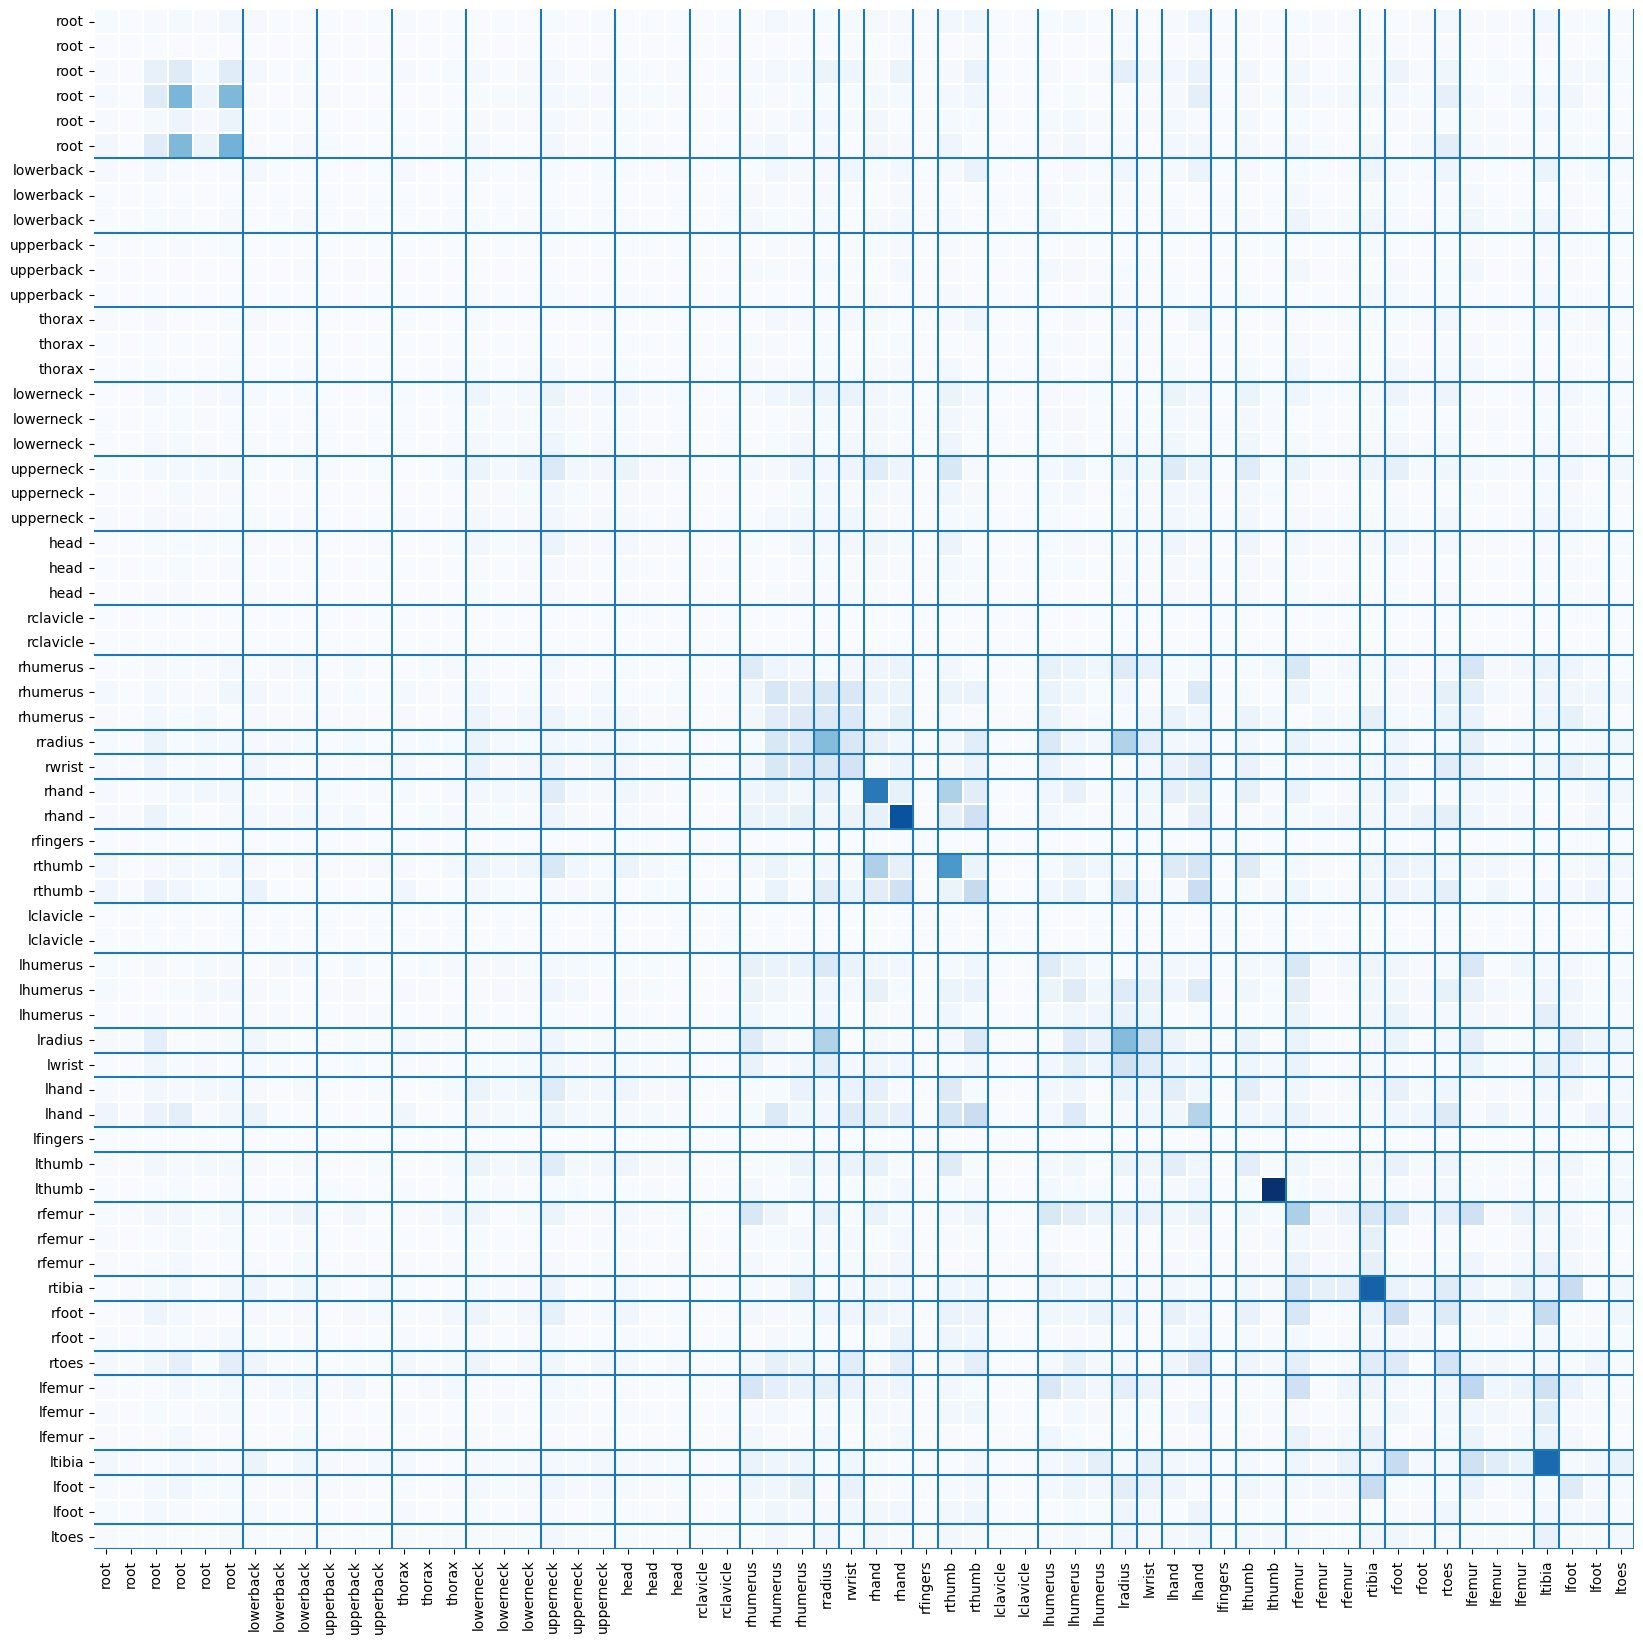

In [635]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
L = tfp.math.fill_triangular(model.kernel.L)
P = tf.linalg.matmul(L, tf.transpose(L)).numpy()
full_P = Pd @ P @ Pd.T
full_P = np.abs(full_P)
h = sns.heatmap(full_P, annot=False, square=True, cmap='Blues', fmt='.1f', vmax=np.max(P), vmin=0, center=np.max(P)/2, linewidth=.3, cbar=False, ax=ax)
h.set_xticklabels(sensors_names)
h.set_yticklabels(sensors_names)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=360)
ax.hlines(sensors_mask, *ax.get_xlim())
ax.vlines(sensors_mask, *ax.get_xlim())
plt.show()